# Домашнее задание №8: «Недвижимость и регрессия» [\[link\]](http://mit.spbau.ru/sewiki/images/c/c0/ML17-Homework8.pdf)

## Working with the data

In [1]:
import numpy as np


data = np.genfromtxt("boston.csv", skip_header=15, delimiter=",")
X_raw, Y_raw = data[:, :-1], data[:, -1]
del data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize


def gen_test_train(*, ratio=0.2, do_norm=False):
    params = train_test_split(X_raw, Y_raw, test_size=ratio)
    if do_norm:
        for M in params:
            normalize(M if len(M.shape) > 1 else M[:, np.newaxis],
                      axis=0, copy=False)
    return params

In [3]:
def sample(size, *, weights):
    X = np.ones((size, 2))
    X[:, 1] = np.random.gamma(4., 2., size)
    y = X.dot(np.asarray(weights))
    y += np.random.normal(0, 1, size)
    return X[:, 1:], y

## Linear regression

### NormalLR

In [4]:
import numpy.linalg as la


class NormalLR:
    def __init__(self, *, use_l2=False, l2_coef=1):
        self.weights = None
        self.use_l2 = use_l2
        self.l2_coef = l2_coef

    def fit(self, X, Y):
        m = X.shape[1]
        add = self.l2_coef * (np.eye(m) if self.use_l2 else np.zeros((m, m)))
        self.weights = la.inv(X.T @ X + add) @ X.T @ Y
        return self

    def predict(self, X):
        return X @ self.weights

### GradientLR

In [5]:
class GradientLR:
    def __init__(self, *, alpha=0.01, eps=None, max_iter=100000, use_l2=False, l2_coef=1):
        self.weights = None
        self.alpha = alpha
        self.eps = eps or alpha / 100
        self.max_iter = max_iter
        self.use_l2 = use_l2
        self.l2_coef = l2_coef

    def fit(self, X, Y):
        n, m = X.shape
        weights = np.random.uniform(-1. / (2 * m), 1. / (2 * m), m)
        iter_num = 0
        while True:
            prev_weights = weights.copy()
            add = self.l2_coef * (weights if self.use_l2 else np.zeros(m))
            weights -= (2 * self.alpha / n) * X.T @ (X @ weights - Y) + add
            iter_num += 1
            if la.norm(weights - prev_weights) <= self.eps or iter_num >= self.max_iter:
                break
        self.weights = weights
        return self

    def predict(self, X):
        return X @ self.weights

## Test

### Useful funcs

In [6]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [7]:
from matplotlib import pyplot as plt


def visualize(X, Y_true, Y_pred):
    plt.scatter(X, Y_true)
    plt.plot(X, Y_pred, color="red")
    plt.show()

### NormalLR

In [8]:
X_train, X_test, Y_train, Y_test = gen_test_train(do_norm=True)
mse(Y_test, NormalLR().fit(X_train, Y_train).predict(X_test))

0.00042847783312844018

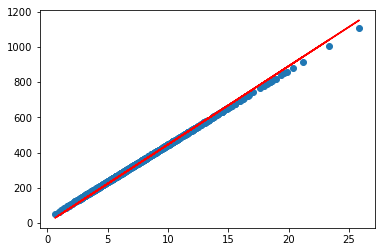

In [9]:
X, Y_true = sample(1000, weights=[24., 42.])
visualize(X, Y_true, NormalLR().fit(X, Y_true).predict(X))

### GradientLR

In [10]:
X_train, X_test, Y_train, Y_test = gen_test_train(do_norm=True)
mse(Y_test, GradientLR().fit(X_train, Y_train).predict(X_test))

0.006669138744207514

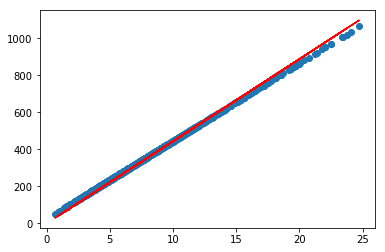

In [11]:
X, Y_true = sample(1000, weights=[24., 42.])
visualize(X, Y_true, GradientLR().fit(X, Y_true).predict(X))

### Compare

In [12]:
from itertools import product, chain


sample_sizes = 128, 256, 512, 1024
weights = ()
samples = (lambda s=s, w=w: (lambda t: (t[0],) * 2 + (t[1],) * 2)(sample(size=s, weights=w))
           for s, w in product(sample_sizes, weights))
do_norms = True,
housess = (lambda d=d: gen_test_train(do_norm=d) for d in do_norms)
datas = chain(samples, housess)
use_l2s = False, True
l2_coefs = .1, .25, .5, .1
normal_lrs = (NormalLR(use_l2=u, l2_coef=c)
              for u, c in product(use_l2s, l2_coefs))
alphas = 1e-2,
gradient_lrs = (GradientLR(alpha=a, use_l2=u, l2_coef=c)
                for a, u, c in product(alphas, use_l2s, l2_coefs))
lrs = chain(normal_lrs, gradient_lrs)


for lr, data in product(lrs, datas):
    X_train, X_test, Y_train, Y_test = data()
    # use can print some info about alg or data right here
    mse(Y_test, lr.fit(X_train, Y_train).predict(X_test))

## Q&A

* **Какой из подходов имеет меньшее значение средней ошибки?**

    В среднем, меньшую ошибку дает NormalLR на выборке размера $128$.

* **Как ведут себя алгоритмы в зависимости от размера выборки?**

    Ответ выдается моментально. Ошибка растет с увеличением размера выборки.
   
* **Что можно сказать о времени работы каждого из алгоритмов?**

    На маленьких выборках - ответ выдается моментально. На больших, градиентному требуется время на схождение.

* **Какой из подходов имеет меньшее значение средней ошибки? Согласуется ли результат с полученным на симулированных данных?**

    Меньшую ошибку выдает NormalLR. Да, согласуется.

* **Как вы считаете, требуется ли нормировка признаков в случае данных о стоимости недвижимости? Объясните, почему.**

    Нужна. Так увеличивается скорость схождения градиента.

* **Интерпретируйте коэффициенты регрессии, полученные одним из алгоритмов. Какой из признаков даёт наибольший вклад в стоимость недвижимости?**

    Судя по одному из вектору коэффицентов, наибольший вклад дает $6$ой признак (average number of rooms per dwelling).

* **Какой из алгоритмов лучше подходит для задачи предсказания стоимости? Почему?**

    NormalLR. Быстрее и точнее.

* **Опишите влияние регуляризации на значение среднего квадрата ошибки.**

    Для обоих алгоритмов, регуляризация влияет отрицательно, увеличивая mse.